In [2]:
%load_ext autoreload
%autoreload 2

# TODO: Think about plotting subset sizes against predicted probability? (confidence)

DATASET_NAME = "esnli"
LABEL_SPACE = ["entailment", "neutral", "contradiction"]
MODEL_NAME = "deberta_large"
SEED = 42
POOLER = "mean_with_attention"
LAYER = 24

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Load Embeddings
from utils.io import (
    load_dataset_from_hf,
    load_labels_at_split,
)
import numpy as np

# load labels 
dataset = load_dataset_from_hf(dataset=DATASET_NAME)
train_labels = load_labels_at_split(dataset, "train")
eval_labels = load_labels_at_split(dataset, "eval")
train_eval_labels = np.concatenate([train_labels, eval_labels])
test_labels = load_labels_at_split(dataset, "test")

from datasets import DatasetDict, concatenate_datasets
train_eval_dataset = concatenate_datasets([dataset["train"], dataset["eval"]])
dataset_dict = DatasetDict(
    {"train": train_eval_dataset, "test": dataset["test"]}
)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/samsoup/.cache/huggingface/token
Login successful


/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


In [4]:
from typing import Iterable, List
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
import matplotlib.pyplot as plt

# plt.style.use('ggplot') # change this to others by checking plt.style.available

GLOBAL_FIG_COUNTER = 1 

def plot_table(table_string: str):
    # Set up image properties
    font_path = "/usr/share/fonts/truetype/freefont/FreeMono.ttf"
    font_size = 24  # Increase font size for higher resolution
    font = ImageFont.truetype(font_path, font_size)
    padding = 20  # Increase padding for higher resolution

    # Create a dummy image to get the font metrics
    dummy_image = Image.new('RGB', (1, 1))
    draw = ImageDraw.Draw(dummy_image)

    # Calculate the width and height required for the text
    lines = table_string.split('\n')
    max_width = max(draw.textbbox((0, 0), line, font=font)[2] for line in lines)
    line_height = font.getbbox('A')[3]  # Get the height of a single line
    total_height = line_height * len(lines)

    # Create an image with white background
    image = Image.new('RGB', (max_width + padding*2, total_height + padding*2), "white")
    draw = ImageDraw.Draw(image)

    # Draw the text on the image
    y = padding
    for line in lines:
        draw.text((padding, y), line, fill="black", font=font)
        y += line_height

    # Save the image
    global GLOBAL_FIG_COUNTER
    image.save(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
    GLOBAL_FIG_COUNTER += 1

def plot_histogram(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: Iterable[int], 
    test_labels: Iterable[int], 
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10,6),
):
    plt.figure(figsize=figsize)
    n, bins, edges = plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black',
        alpha=0.7
    )
    # plt.gca().set_facecolor('white') # white background
    plt.grid(color="gray", linestyle="-", linewidth=0.25, alpha=0.5)
    if len(bins) > tick_threshold:
        # too much bins, only show a percentage of ticks
        n = int(1 / tick_percentage_to_show)
    else:
        n = 1
    plt.xticks(bins[::n], rotation="vertical")
    # tick_locs = np.arange(0, max(num_examples_per_subset), tick_inc)
    # plt.xticks(tick_locs, rotation='vertical')
    # plt.xticks(bin_edges, rotation="vertical")
    plt.xlim(left=0) # adjust for bar width
    # plt.subplots_adjust(right=0.9)  # Eliminate extra right white space
    plt.xlabel('Valid Subset Size')
    plt.ylabel('Frequency')
    plt.title(
        f'Histogram of Size of Valid Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    plt.text(
        max(num_examples_per_subset), 
        max(plt.hist(
            num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
        )[0]), 
        f'{len(num_examples_per_subset)}/{len(test_labels)}', 
        horizontalalignment='right', verticalalignment='top'
    )
    # Calculate the median and plot as a line
    median_value = np.median(num_examples_per_subset)
    plt.axvline(
        median_value, color='red', linestyle='--', linewidth=2, label='Median'
    )
    # Label the median line with a piece of text
    text_height = max(plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
    )[0]) * 0.8
    plt.text(
        median_value * 1.05, text_height, f'Median: {median_value}', color='red', 
        fontsize=12
    )
    # Darken the axis lines
    # plt.gca().spines['bottom'].set_color('black')
    # plt.gca().spines['left'].set_color('black')
    plt.tight_layout()
    global GLOBAL_FIG_COUNTER
    plt.savefig(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
    GLOBAL_FIG_COUNTER += 1
    plt.show()

def plot_bars(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: List[int],
):
    sorted_data = sorted(num_examples_per_subset)
    # Plotting the sorted data as bars
    plt.bar(range(len(sorted_data)), sorted_data, color='skyblue', edgecolor='black')
    plt.xticks([])
    plt.ylabel('Valid Subset Size')
    plt.title(
        f'Distribution of Size of Valid Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    global GLOBAL_FIG_COUNTER
    plt.savefig(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
    GLOBAL_FIG_COUNTER += 1
    plt.show()

def plot_violin(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: List[int],
):
    sns.violinplot(num_examples_per_subset, color='skyblue', cut=0)
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Valid Subset Sizes')
    plt.title(
        f'Distribution of Size of Valid Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    global GLOBAL_FIG_COUNTER
    plt.savefig(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
    GLOBAL_FIG_COUNTER += 1
    plt.show()

In [5]:
from tabulate import tabulate
import pandas as pd
# Function to get dataset details
def get_dataset_details(dataset_dict):
    details = []
    for split in dataset_dict:
        num_rows = len(dataset_dict[split])
        label_distribution = set(dataset_dict[split]['label'])
        label_counts = dataset_dict[split].to_pandas()['label'].value_counts().sort_index().tolist()
        details.append({
            'Split': split,
            'Number of Rows': num_rows,
            'Label Distribution': dict(zip(label_distribution, label_counts))
        })
    return details

# Get dataset details
dataset_details = get_dataset_details(dataset)

# Convert details to DataFrame for better visualization
df_details = pd.DataFrame(dataset_details)

table_str = tabulate(df_details, headers='keys', tablefmt='psql', showindex=False)
print(table_str)

plot_table(table_str)

+---------+------------------+-----------------------------------+
| Split   |   Number of Rows | Label Distribution                |
|---------+------------------+-----------------------------------|
| train   |           549361 | {0: 183414, 1: 182762, 2: 183185} |
| test    |             9824 | {0: 3368, 1: 3219, 2: 3237}       |
| eval    |             9842 | {0: 3329, 1: 3235, 2: 3278}       |
+---------+------------------+-----------------------------------+


In [6]:
## For plotting subset sizes against each other 
subset_sizes = {
    "Yang Fast": None,
    "Yang Slow": None,
    "KNN": None,
    # "SVM": None,
    "LGBM": None,
    "LMeans": None
}

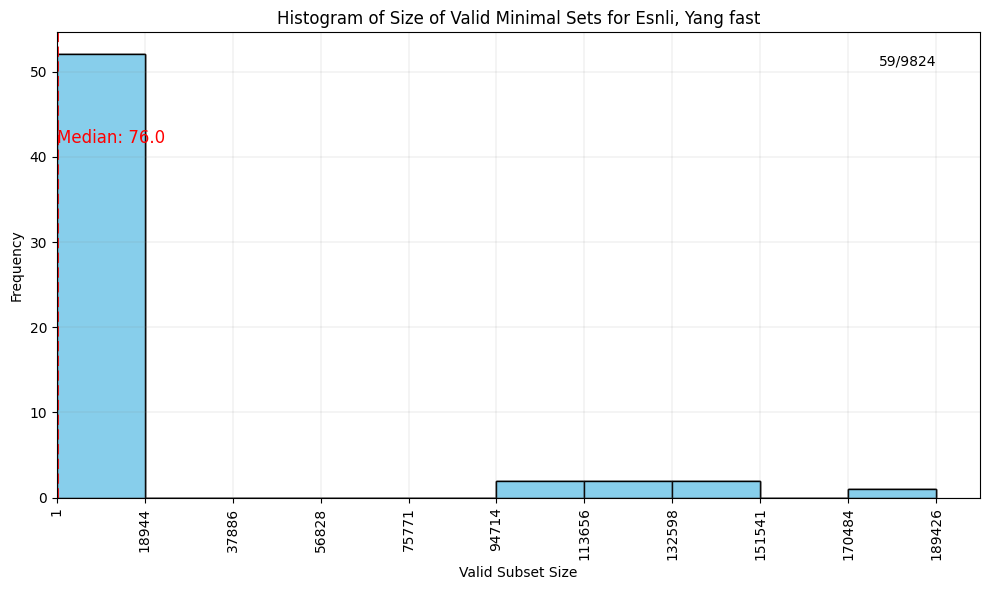

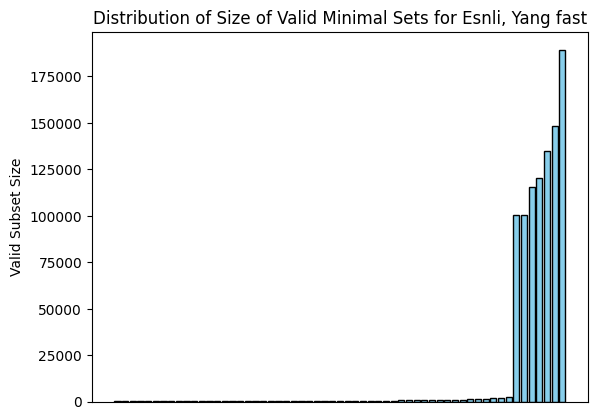

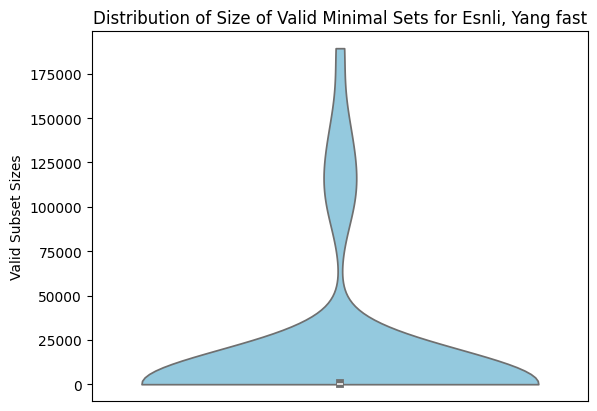

In [7]:
## Visualize Yang 2023 Algorithm1


from MinimalSubsetToFlipPredictions.evaluate.evaluate import compute_valid_subset_sizes
from utils.io import load_pickle

name = "yang_fast"
filename = f"{DATASET_NAME}_{MODEL_NAME}_{name}.pickle"
flip_list = load_pickle(filename)

filename = f'{DATASET_NAME}_{MODEL_NAME}_{name}_is_valid.pickle'
is_valid = load_pickle(filename)

valid_subset_sizes = compute_valid_subset_sizes(
    flip_list, is_valid
)
subset_sizes["Yang Fast"] = valid_subset_sizes

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name=" ".join(name.split(sep="_")).capitalize(),
    num_examples_per_subset=valid_subset_sizes,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)


plot_bars(
    dataset_name=DATASET_NAME, 
    algo_name=" ".join(name.split(sep="_")).capitalize(), 
    num_examples_per_subset=valid_subset_sizes
)

plot_violin(
    dataset_name=DATASET_NAME, 
    algo_name=" ".join(name.split(sep="_")).capitalize(), 
    num_examples_per_subset=valid_subset_sizes
)

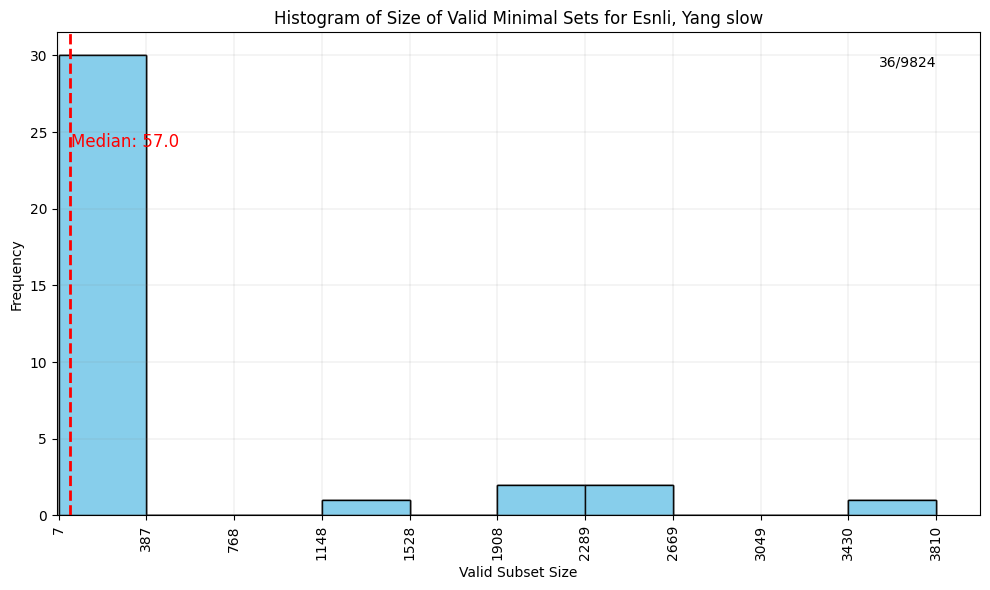

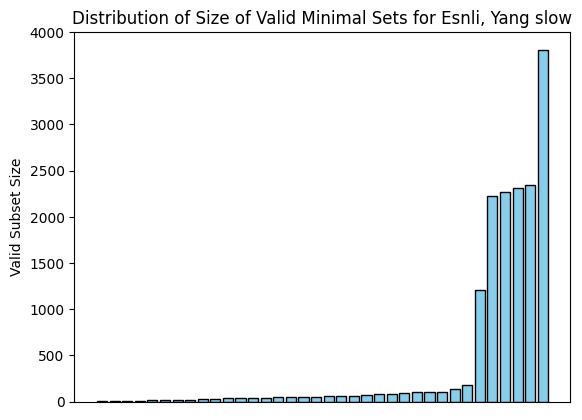

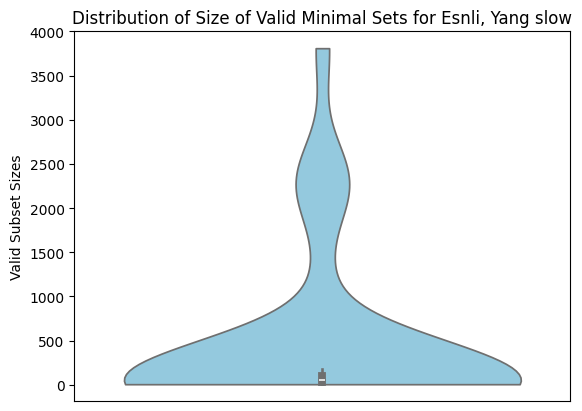

In [8]:
## Visualize Yang 2023 Algorithm2 

from MinimalSubsetToFlipPredictions.evaluate.evaluate import compute_valid_subset_sizes
from utils.io import load_pickle

name = "yang_slow"
filename = f"{DATASET_NAME}_{MODEL_NAME}_{name}.pickle"
flip_list = load_pickle(filename)

filename = f'{DATASET_NAME}_{MODEL_NAME}_{name}_is_valid.pickle'
is_valid = load_pickle(filename)

valid_subset_sizes = compute_valid_subset_sizes(
    flip_list, is_valid
)
subset_sizes["Yang Slow"] = valid_subset_sizes

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name=" ".join(name.split(sep="_")).capitalize(),
    num_examples_per_subset=valid_subset_sizes,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

plot_bars(
    dataset_name=DATASET_NAME, 
    algo_name=" ".join(name.split(sep="_")).capitalize(), 
    num_examples_per_subset=valid_subset_sizes
)
plot_violin(
    dataset_name=DATASET_NAME, 
    algo_name=" ".join(name.split(sep="_")).capitalize(), 
    num_examples_per_subset=valid_subset_sizes
)

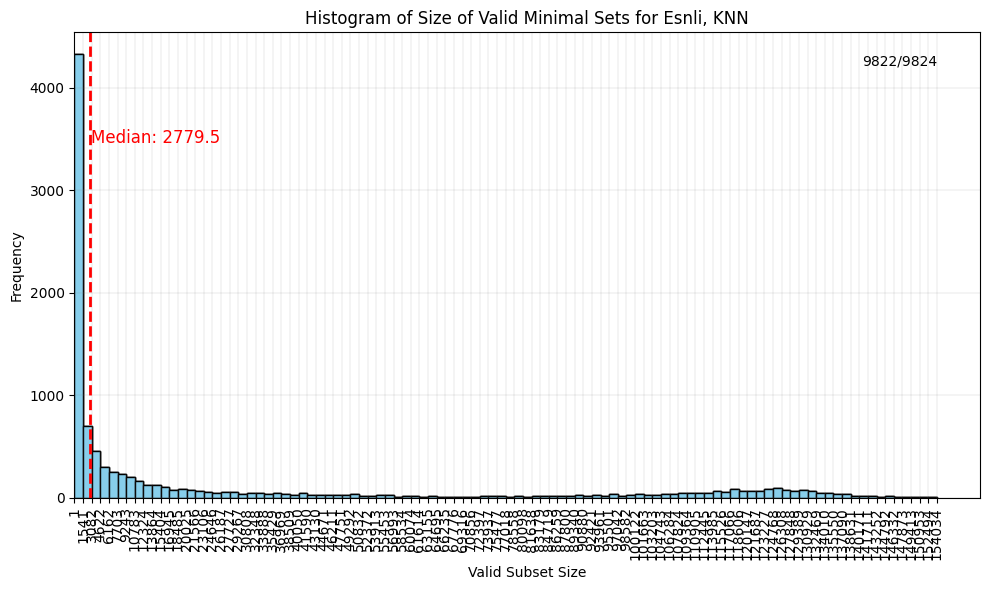

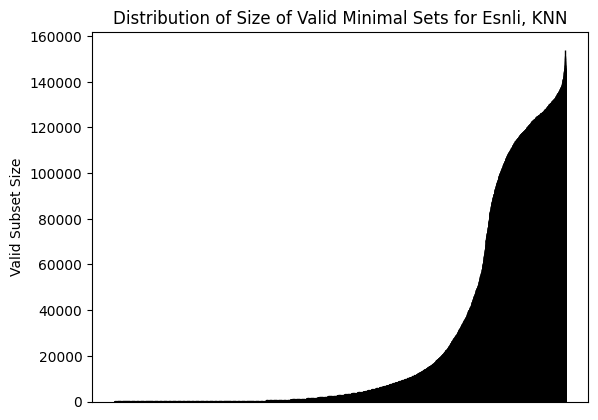

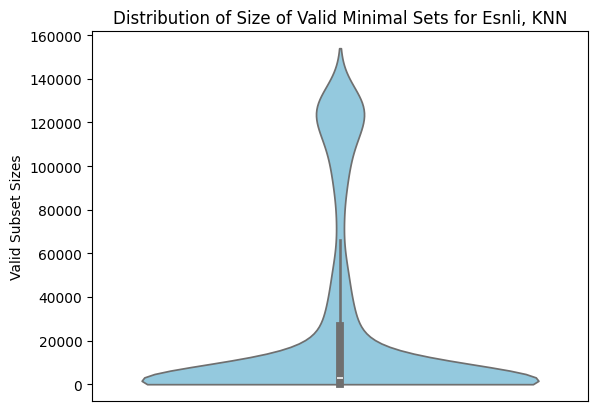

In [9]:
## Visualize KNN


from MinimalSubsetToFlipPredictions.evaluate.evaluate import compute_valid_subset_sizes
from utils.io import load_pickle

name = "KNN"
filename = f"{DATASET_NAME}_{MODEL_NAME}_{name}.pickle"
flip_list = load_pickle(filename)

filename = f'{DATASET_NAME}_{MODEL_NAME}_{name}_is_valid.pickle'
is_valid = load_pickle(filename)

valid_subset_sizes = compute_valid_subset_sizes(
    flip_list, is_valid
)
subset_sizes[name] = valid_subset_sizes

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name=name,
    num_examples_per_subset=valid_subset_sizes,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

plot_bars(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)
plot_violin(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)

In [10]:
# ## Visualize SVM
# from utils.io import load_json

# data = load_json("toxigen_deberta_large_SVM_minimal_subsets.json")

# name = "SVM"

# num_examples = []
# for d in data:
#     if d['minimum_subset']:
#         num_examples.append(len(d['minimum_subset']))

# plot_histogram(
#     dataset_name=DATASET_NAME,
#     algo_name=name,
#     num_examples_per_subset=num_examples,
#     test_labels=test_labels,
#     bins=50,
#     tick_threshold=100,
#     tick_percentage_to_show=0.5,
#     figsize=(10, 6)
# )

# plot_bars(
#     dataset_name=DATASET_NAME, 
#     algo_name=name, 
#     num_examples_per_subset=valid_subset_sizes
# )
# plot_violin(
#     dataset_name=DATASET_NAME, 
#     algo_name=name, 
#     num_examples_per_subset=valid_subset_sizes
# )

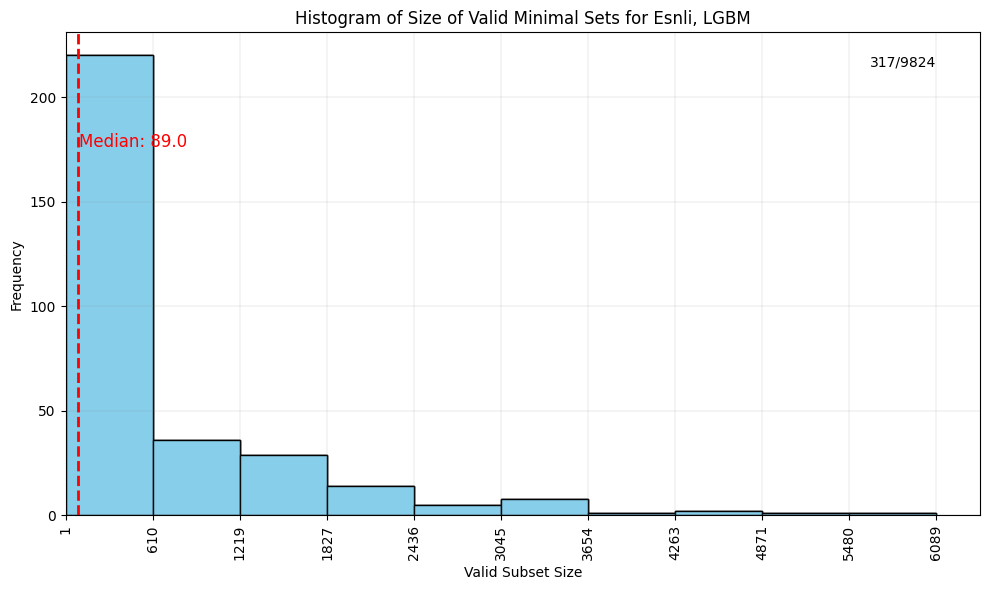

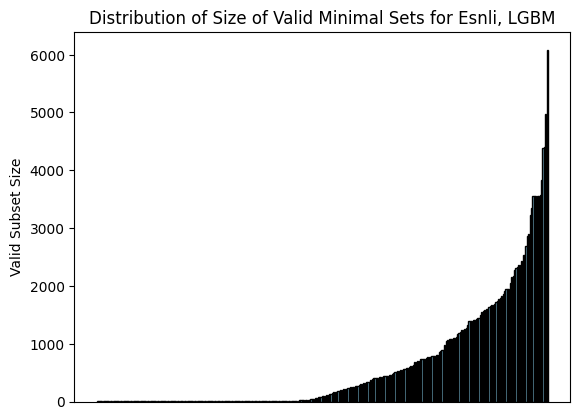

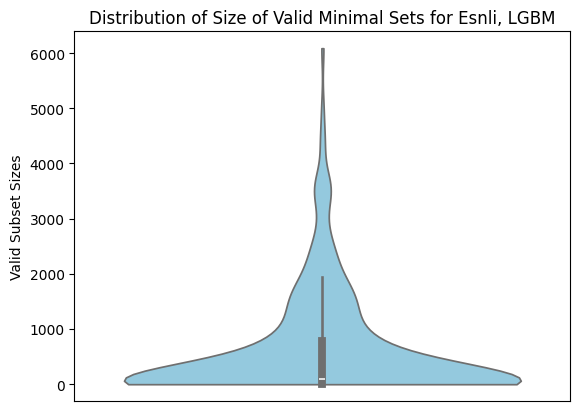

In [11]:
## Visualize LGBM


from MinimalSubsetToFlipPredictions.evaluate.evaluate import compute_valid_subset_sizes
from utils.io import load_pickle

name = "LGBM"
filename = f"{DATASET_NAME}_{MODEL_NAME}_{name}.pickle"
flip_list = load_pickle(filename)

filename = f'{DATASET_NAME}_{MODEL_NAME}_{name}_is_valid.pickle'
is_valid = load_pickle(filename)

valid_subset_sizes = compute_valid_subset_sizes(
    flip_list, is_valid
)
subset_sizes[name] = valid_subset_sizes

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name=name,
    num_examples_per_subset=valid_subset_sizes,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

plot_bars(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)
plot_violin(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)

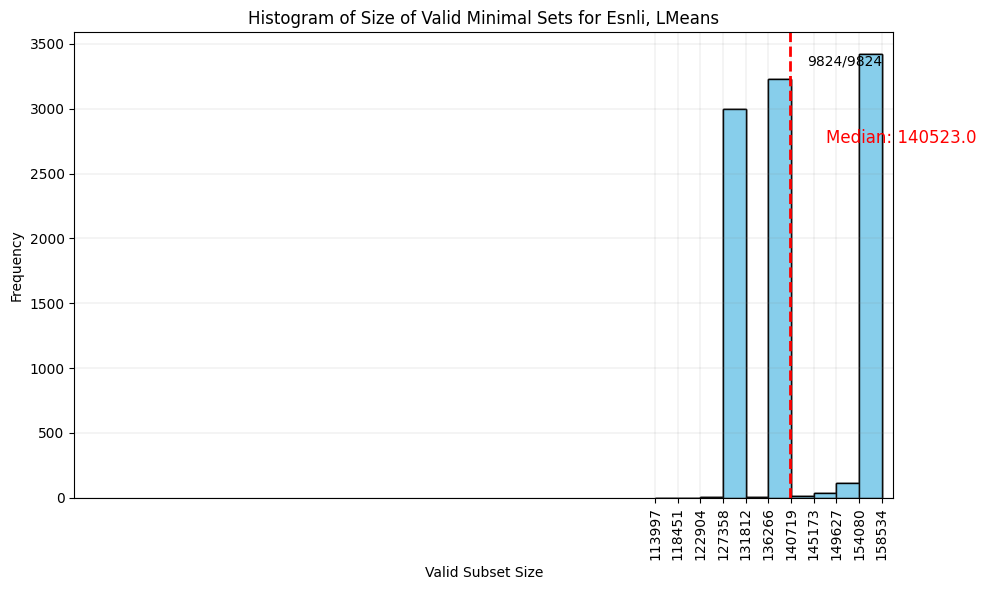

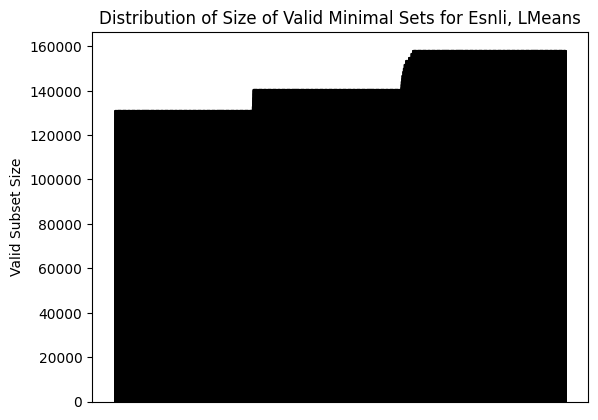

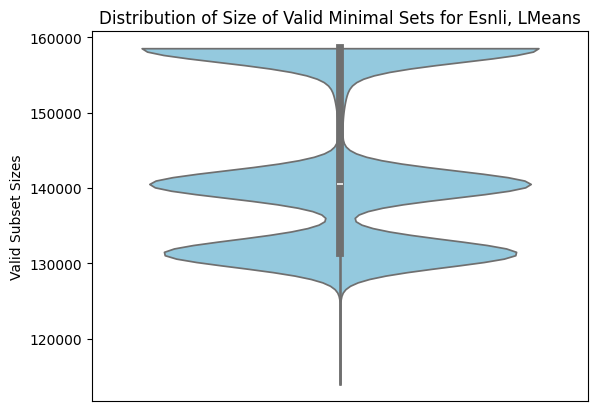

In [12]:
## Visualize LMeans


from MinimalSubsetToFlipPredictions.evaluate.evaluate import compute_valid_subset_sizes
from utils.io import load_pickle

name = "LMeans"
filename = f"{DATASET_NAME}_{MODEL_NAME}_{name}.pickle"
flip_list = load_pickle(filename)

filename = f'{DATASET_NAME}_{MODEL_NAME}_{name}_is_valid.pickle'
is_valid = load_pickle(filename)

valid_subset_sizes = compute_valid_subset_sizes(
    flip_list, is_valid
)
subset_sizes[name] = valid_subset_sizes

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name=name,
    num_examples_per_subset=valid_subset_sizes,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

plot_bars(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)
plot_violin(
    dataset_name=DATASET_NAME, 
    algo_name=name, 
    num_examples_per_subset=valid_subset_sizes
)

In [13]:
from tabulate import tabulate

# LMeans is a bit special: looks like we only have ~15 unique 
# subset values, so instead show frequency of thse values
unique_values, counts = np.unique(valid_subset_sizes, return_counts=True)
print("Unique values:", unique_values.tolist())
print("Counts:", counts)

df = pd.DataFrame({'LMeans Unique Minimal Subset Sizes': unique_values, 'Counts': counts})

table_str = tabulate(df, headers='keys', tablefmt='psql', showindex=False)
print(table_str)

plot_table(table_str)

Unique values: [113997, 121347, 123552, 126126, 131347, 131569, 132999, 133083, 134429, 134496, 135859, 137289, 138719, 140149, 140523, 141579, 143010, 144149, 145620, 147096, 147240, 148730, 148860, 150364, 150471, 151998, 152091, 153632, 153711, 155266, 156900, 156942, 158534]
Counts: [   1    1    1    2 2998    1    1    1    1    2    4    4    2    3
 3220    5    3    9    7   16    2    8    2   19    1   25    6   58
    3   58   29    1 3330]
+--------------------------------------+----------+
|   LMeans Unique Minimal Subset Sizes |   Counts |
|--------------------------------------+----------|
|                               113997 |        1 |
|                               121347 |        1 |
|                               123552 |        1 |
|                               126126 |        2 |
|                               131347 |     2998 |
|                               131569 |        1 |
|                               132999 |        1 |
|                      

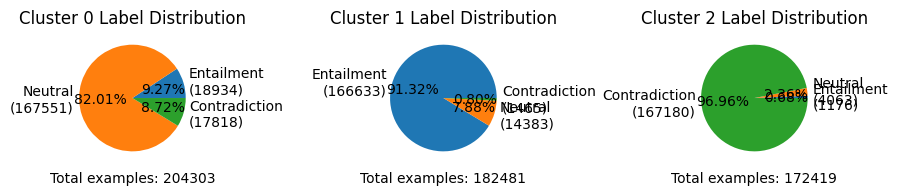

In [14]:
# Show Cluster Distribution
from utils.io import load_wrapperbox
from utils.partition import get_partition_X
import matplotlib.pyplot as plt

lmeans_clf = load_wrapperbox(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="LMeans",
)

fig, axs = plt.subplots(1, lmeans_clf.kmeans_.n_clusters, figsize=(9, 3))
n_clusters = lmeans_clf.kmeans_.n_clusters
for cluster_id, ax in zip(range(n_clusters), axs):
    _, train_indices = get_partition_X(lmeans_clf.kmeans_.labels_, cluster_id)
    cluster_labels = train_eval_labels[train_indices]
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    
    # For plotting cluster distribution
    percents = [counts / np.sum(label_counts) for counts in label_counts ]
    labels = [
        f'{label.capitalize()}\n({count})'
        for label, p, count in zip(LABEL_SPACE, percents, label_counts)
    ]
    ax.pie(label_counts, labels = labels, autopct='%1.2f%%')
    ax.set_title(f'Cluster {cluster_id} Label Distribution')
    ax.text(
        0.5, -0.1, f'Total examples: {np.sum(label_counts)}', 
        horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes
    )
plt.tight_layout()
plt.show()

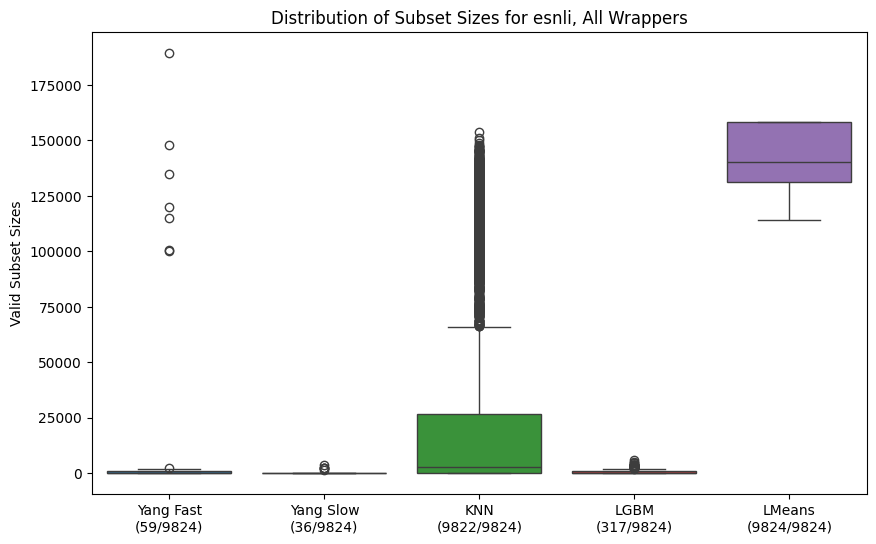

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create x-tick labels with the count information
total = test_labels.size
xtick_labels = [f"{k}\n({len(v)}/{total})" for k, v in subset_sizes.items()]

plt.figure(figsize=(10, 6))
sns.boxplot(data=list(subset_sizes.values()))
plt.xticks(ticks=range(len(subset_sizes)), labels=xtick_labels)
# sns.violinplot(data=list(subset_sizes.values()), cut=0)_presentationbels)
plt.xlabel('')
plt.ylabel('Valid Subset Sizes')
plt.title(f"Distribution of Subset Sizes for {DATASET_NAME}, All Wrappers")
plt.savefig(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
GLOBAL_FIG_COUNTER += 1
plt.show()

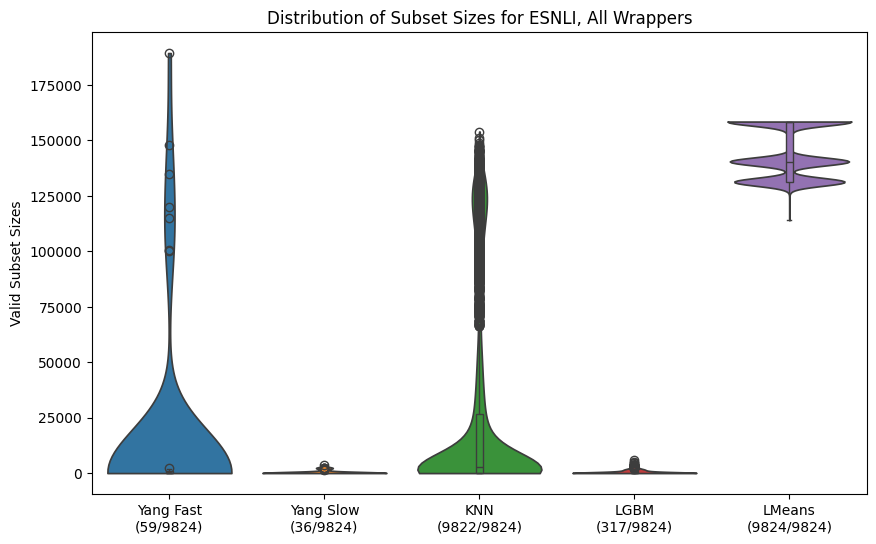

In [24]:
# Create x-tick labels with the count information
total = test_labels.size
xtick_labels = [f"{k}\n({len(v)}/{total})" for k, v in subset_sizes.items()]

plt.figure(figsize=(10, 6))
sns.violinplot(data=list(subset_sizes.values()), cut=0, inner=None)
# Overlay the box plot
sns.boxplot(data=list(subset_sizes.values()), width=0.05, showcaps=True, boxprops={'zorder': 2}, 
whiskerprops={'zorder': 2}, capprops={'zorder': 2}, medianprops={'zorder': 2})

# sns.boxplot(x='Category', y='Value', data=df, width=0.2, showcaps=True, boxprops={'zorder': 2}, 
#             whiskerprops={'zorder': 2}, capprops={'zorder': 2}, medianprops={'zorder': 2})
plt.xticks(ticks=range(len(subset_sizes)), labels=xtick_labels)
# sns.violinplot(data=list(subset_sizes.values()), cut=0)_presentationbels)
plt.xlabel('')
plt.ylabel('Valid Subset Sizes')
plt.title(f"Distribution of Subset Sizes for {DATASET_NAME.upper()}, All Wrappers")
plt.savefig(f'figures/figure{GLOBAL_FIG_COUNTER}.png')
GLOBAL_FIG_COUNTER += 1
plt.show()

In [16]:
## Collect all figures into a powerpoint

from pptx import Presentation
from pptx.util import Inches
from PIL import Image

# Function to add slide with an image scaled to fit within a specific size
def add_scaled_image_slide(prs, image_path, title_text, max_width=Inches(8.5), max_height=Inches(6)):
    # Open the image using PIL to get its size
    with Image.open(image_path) as img:
        img_width, img_height = img.size
    
    # Calculate the scaling factor to fit the image within the specified max width and height
    width_ratio = max_width / img_width
    height_ratio = max_height / img_height
    scale_factor = min(width_ratio, height_ratio)
    
    # Calculate the new size based on the scale factor
    new_width = img_width * scale_factor
    new_height = img_height * scale_factor
    
    # Add the slide
    slide_layout = prs.slide_layouts[6]  # Choosing a blank slide layout
    slide = prs.slides.add_slide(slide_layout)
    # title = slide.shapes.title
    # title.text = title_text
    
    # Add the picture scaled to the new size
    slide.shapes.add_picture(image_path, Inches(1), Inches(1), width=new_width, height=new_height)


# Create a presentation object
prs = Presentation()

# Add a slide for each image
for i in range(1, GLOBAL_FIG_COUNTER):  # Replace n with the number of figures you have
    add_scaled_image_slide(
        prs=prs,
        image_path=f'figures/figure{i}.png',
        title_text="",
    )

# Save the presentation
prs.save(f'{DATASET_NAME}_presentation.pptx')
